# The Problem Statement

Build a model that predicts whether a user will click on a post. We are to evaluate your modeling process. We'd like to see how you approach the data, feature engineering, model architecture, and evaluation and how you organize code. Please don't think of this as a leet-code problem, and feel free to add notes on things you might consider in the real world if you had more time.

# Data

Suppose we live in a world where there are only 3 subreddits: r/cats, r/dogs and r/stocks.

You will receive 5000 rows of data, where each row represents a training example, where:

col1: how much time a user spent on r/cats in the past week (hours)

col2: how much time a user spent on r/dogs in the past week (hours)

col3: how much time a user spent on r/stocks in the past week (hours)

col4: the subreddit of the post

Col5 is your target, 1 == click, 0 == no click.

# Sample Data

[[0.611, 2.322, 0.171, 'stocks', 0],

 [0.85, 0.341, 4.353, 'cats', 0],

 [0.861, 1.973, 0.851, 'stocks', 0],

 [2.357, 2.924, 3.629, 'dogs', 0],

 [1.927, 3.665, 7.456, 'cats', 0],

 [2.109, 0.443, 7.042, 'stocks', 1],

 [1.485, 3.839, 3.67, 'dogs', 0]]

In the interest of time, use accuracy as the evaluation metric.

import json
with open('training_data.json', 'r') as ifile:
   data = json.load(ifile)

# Step 1: Define the Problem

we want to classify if a user will click on a post or not based on the time spent on the subreddit and the subreddit of the post.

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, confusion_matrix

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve

# Step 2: Gather the Data

In [2]:
path = 'datasets/training_data.json'
df = pd.read_json(path)
# rename columns
df.columns = ['cats', 'dogs', 'stocks', 'community', 'label']
df.head()

,cats,dogs,stocks,community,label
0,2.823,1.258,3.855,stocks,0
1,0.154,3.789,5.502,cats,0
2,0.203,2.224,2.823,stocks,0
3,0.153,2.634,4.691,cats,0
4,4.388,1.569,1.685,cats,1


# Step 3: explore the data

In [3]:
df.shape

(5000, 5)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   cats       5000 non-null   float64
 1   dogs       5000 non-null   float64
 2   stocks     5000 non-null   float64
 3   community  5000 non-null   object 
 4   label      5000 non-null   int64  
dtypes: float64(3), int64(1), object(1)
memory usage: 195.4+ KB


In [5]:
df.describe()

,cats,dogs,stocks,label
count,5000.000000,5000.000000,5000.000000,5000.000000
mean,1.854835,1.857406,3.722195,0.411200
std,1.159494,1.174414,2.307885,0.492101
min,0.000000,0.001000,0.000000,0.000000
25%,0.884000,0.867750,1.788250,0.000000
50%,1.777000,1.775000,3.584500,0.000000
75%,2.693250,2.715000,5.380500,1.000000
max,4.959000,4.926000,9.868000,1.000000


In [6]:
df['label'].value_counts()

label
0    2944
1    2056
Name: count, dtype: int64

# Step 4: Preprocess the data

In [7]:
# one-hot encoding of 'community' column
df = pd.get_dummies(df, columns=['community'])

# map 'label' column to 0 and 1
df['community_cats'] = df['community_cats'].map({False: 0, True: 1})
df['community_dogs'] = df['community_dogs'].map({False: 0, True: 1})
df['community_stocks'] = df['community_stocks'].map({False: 0, True: 1})

df.head()

,cats,dogs,stocks,label,community_cats,community_dogs,community_stocks
0,2.823,1.258,3.855,0,0,0,1
1,0.154,3.789,5.502,0,1,0,0
2,0.203,2.224,2.823,0,0,0,1
3,0.153,2.634,4.691,0,1,0,0
4,4.388,1.569,1.685,1,1,0,0


In [8]:
duplicated_mask = df.duplicated()
duplicated_rows = df[duplicated_mask]
print(len(duplicated_rows))

0


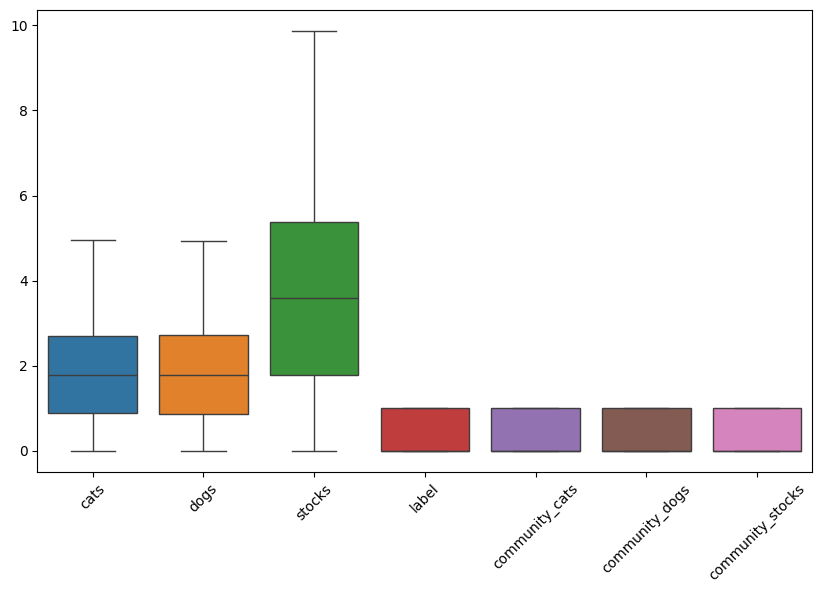

In [9]:
# visualize the data
plt.figure(figsize=(10, 6))
sns.boxplot(data=df)
plt.xticks(rotation=45)
plt.show()

<Figure size 1000x600 with 0 Axes>

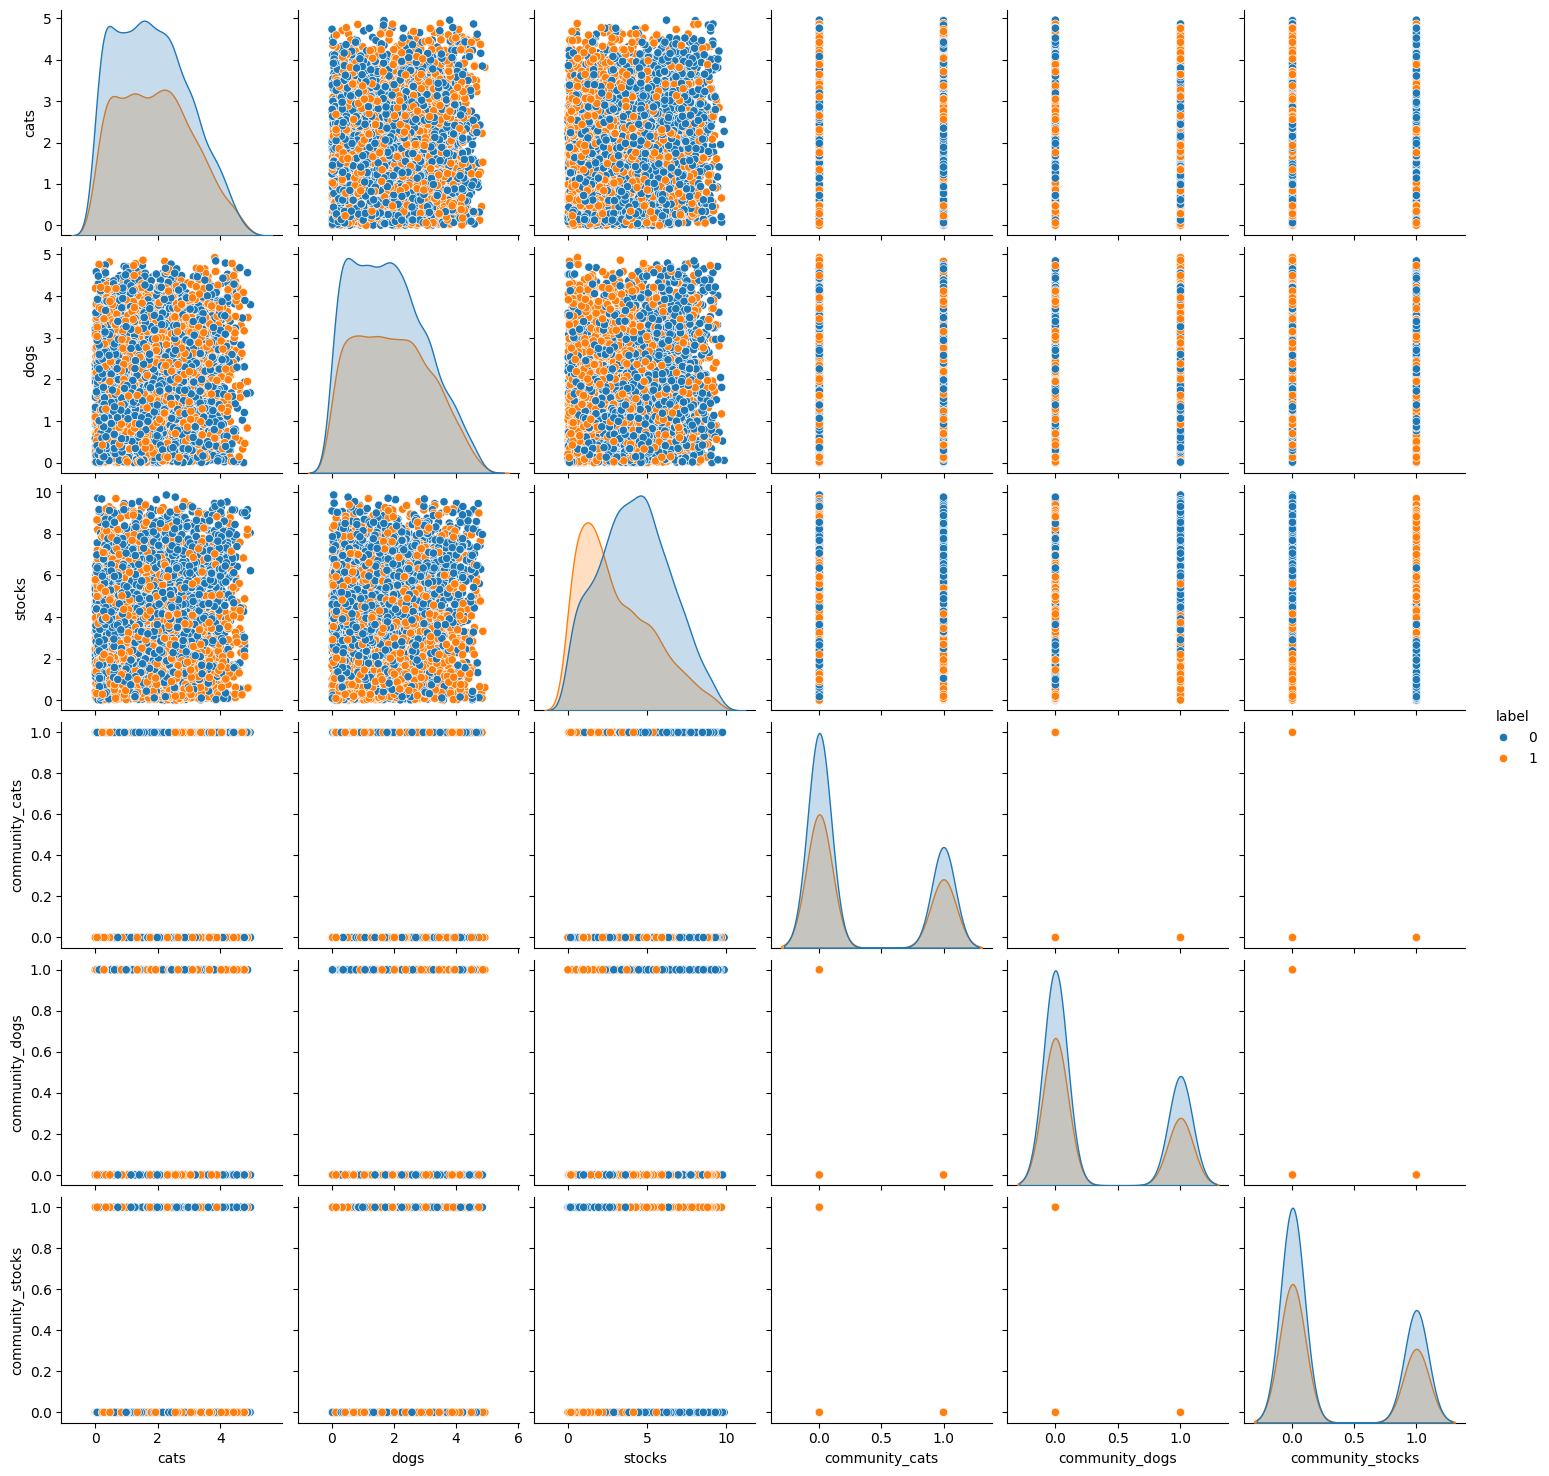

In [10]:
plt.figure(figsize=(10, 6))
sns.pairplot(df, hue='label')
plt.show()

In [12]:
# spearman correlation
# corr = df[df.columns.drop('community')].corr(method='spearman')
# plt.figure(figsize=(10, 6))
# sns.heatmap(corr, annot=True, cmap='coolwarm')
# plt.show()

# 5 : Model Selection

In [13]:
features_col = ['cats', 'dogs', 'stocks', 'community_cats', 'community_dogs', 'community_stocks']
label_col = ['label']

In [14]:
x = df[features_col]
y = df[label_col]

In [15]:
x_train, x_test, y_train, y_test = train_test_split(x.values, y.values, random_state=42, stratify=y)

In [16]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(x_train, y_train)

/home/saul/.pyenv/versions/3.11.8/envs/machineLearning/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestClassifier(random_state=42)

In [17]:
rf_predictions = rf.predict(x_test)

In [19]:
print('Random Forest Classifier')
print(classification_report(y_test, rf_predictions))
print('Accuracy:', accuracy_score(y_test, rf_predictions))
print('Confusion Matrix:: \n', confusion_matrix(y_test, rf_predictions))

Random Forest Classifier
              precision    recall  f1-score   support

           0       0.96      0.97      0.97       736
           1       0.96      0.94      0.95       514

    accuracy                           0.96      1250
   macro avg       0.96      0.96      0.96      1250
weighted avg       0.96      0.96      0.96      1250

Accuracy: 0.96
Confusion Matrix:: 
 [[716  20]
 [ 30 484]]


# Hyper parameter tuning

In [21]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [None, 10, 20, 30],
    'criterion': ['gini', 'entropy']
}

grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search_rf.fit(x_train, y_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
[CV] END criterion=gini, max_depth=None, max_features=auto, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, n_estimators=200; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, n_estimators=200; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, n_estimators=200; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, n_estimators=200; total time=   0.0s


/home/saul/.pyenv/versions/3.11.8/envs/machineLearning/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/saul/.pyenv/versions/3.11.8/envs/machineLearning/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/saul/.pyenv/versions/3.11.8/envs/machineLearning/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/saul/.pyenv/versions/3.11.8/envs/machineLearning/lib/python3.11/sit

[CV] END criterion=gini, max_depth=None, max_features=auto, n_estimators=200; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, n_estimators=300; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, n_estimators=300; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, n_estimators=300; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, n_estimators=300; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, n_estimators=300; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=sqrt, n_estimators=100; total time=   0.3s
[CV] END criterion=gini, max_depth=None, max_features=sqrt, n_estimators=100; total time=   0.3s


/home/saul/.pyenv/versions/3.11.8/envs/machineLearning/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/saul/.pyenv/versions/3.11.8/envs/machineLearning/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/saul/.pyenv/versions/3.11.8/envs/machineLearning/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/saul/.pyenv/versions/3.11.8/envs/machineLearning/lib/python3.11/sit

[CV] END criterion=gini, max_depth=None, max_features=sqrt, n_estimators=100; total time=   0.3s
[CV] END criterion=gini, max_depth=None, max_features=sqrt, n_estimators=100; total time=   0.3s


/home/saul/.pyenv/versions/3.11.8/envs/machineLearning/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/saul/.pyenv/versions/3.11.8/envs/machineLearning/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/saul/.pyenv/versions/3.11.8/envs/machineLearning/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/saul/.pyenv/versions/3.11.8/envs/machineLearning/lib/python3.11/sit

[CV] END criterion=gini, max_depth=None, max_features=sqrt, n_estimators=100; total time=   0.3s
[CV] END criterion=gini, max_depth=None, max_features=log2, n_estimators=100; total time=   0.3s
[CV] END criterion=gini, max_depth=None, max_features=log2, n_estimators=100; total time=   0.3s
[CV] END criterion=gini, max_depth=None, max_features=sqrt, n_estimators=200; total time=   0.6s
[CV] END criterion=gini, max_depth=None, max_features=sqrt, n_estimators=200; total time=   0.6s
[CV] END criterion=gini, max_depth=None, max_features=sqrt, n_estimators=200; total time=   0.6s
[CV] END criterion=gini, max_depth=None, max_features=log2, n_estimators=100; total time=   0.3s
[CV] END criterion=gini, max_depth=None, max_features=sqrt, n_estimators=200; total time=   0.6s
[CV] END criterion=gini, max_depth=None, max_features=sqrt, n_estimators=200; total time=   0.6s


/home/saul/.pyenv/versions/3.11.8/envs/machineLearning/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/saul/.pyenv/versions/3.11.8/envs/machineLearning/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/saul/.pyenv/versions/3.11.8/envs/machineLearning/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/saul/.pyenv/versions/3.11.8/envs/machineLearning/lib/python3.11/sit

[CV] END criterion=gini, max_depth=None, max_features=log2, n_estimators=100; total time=   0.3s
[CV] END criterion=gini, max_depth=None, max_features=log2, n_estimators=100; total time=   0.4s
[CV] END criterion=gini, max_depth=10, max_features=auto, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=10, max_features=auto, n_estimators=100; total time=   0.0s


/home/saul/.pyenv/versions/3.11.8/envs/machineLearning/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/saul/.pyenv/versions/3.11.8/envs/machineLearning/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=gini, max_depth=10, max_features=auto, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=10, max_features=auto, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=10, max_features=auto, n_estimators=100; total time=   0.0s[CV] END criterion=gini, max_depth=None, max_features=sqrt, n_estimators=300; total time=   0.8s

[CV] END criterion=gini, max_depth=10, max_features=auto, n_estimators=200; total time=   0.0s
[CV] END criterion=gini, max_depth=10, max_features=auto, n_estimators=200; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=sqrt, n_estimators=300; total time=   0.9s
[CV] END criterion=gini, max_depth=None, max_features=sqrt, n_estimators=300; total time=   0.9s
[CV] END criterion=gini, max_depth=10, max_features=auto, n_estimators=200; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, n_estimators=200; total time=   0.6s
[CV] END criterion=gini, max_depth=10, max

/home/saul/.pyenv/versions/3.11.8/envs/machineLearning/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/saul/.pyenv/versions/3.11.8/envs/machineLearning/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/saul/.pyenv/versions/3.11.8/envs/machineLearning/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/saul/.pyenv/versions/3.11.8/envs/machineLearning/lib/python3.11/sit

[CV] END criterion=gini, max_depth=10, max_features=sqrt, n_estimators=100; total time=   0.3s
[CV] END criterion=gini, max_depth=10, max_features=sqrt, n_estimators=100; total time=   0.3s
[CV] END criterion=gini, max_depth=None, max_features=log2, n_estimators=300; total time=   0.9s
[CV] END criterion=gini, max_depth=10, max_features=sqrt, n_estimators=100; total time=   0.3s
[CV] END criterion=gini, max_depth=10, max_features=sqrt, n_estimators=100; total time=   0.3s
[CV] END criterion=gini, max_depth=10, max_features=sqrt, n_estimators=100; total time=   0.3s
[CV] END criterion=gini, max_depth=None, max_features=log2, n_estimators=300; total time=   0.9s
[CV] END criterion=gini, max_depth=None, max_features=log2, n_estimators=300; total time=   0.8s
[CV] END criterion=gini, max_depth=None, max_features=log2, n_estimators=300; total time=   0.9s
[CV] END criterion=gini, max_depth=None, max_features=log2, n_estimators=300; total time=   0.9s


/home/saul/.pyenv/versions/3.11.8/envs/machineLearning/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/saul/.pyenv/versions/3.11.8/envs/machineLearning/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/saul/.pyenv/versions/3.11.8/envs/machineLearning/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/saul/.pyenv/versions/3.11.8/envs/machineLearning/lib/python3.11/sit

[CV] END criterion=gini, max_depth=10, max_features=sqrt, n_estimators=200; total time=   0.6s
[CV] END criterion=gini, max_depth=10, max_features=log2, n_estimators=100; total time=   0.3s
[CV] END criterion=gini, max_depth=10, max_features=log2, n_estimators=100; total time=   0.3s
[CV] END criterion=gini, max_depth=10, max_features=sqrt, n_estimators=200; total time=   0.6s
[CV] END criterion=gini, max_depth=10, max_features=log2, n_estimators=100; total time=   0.3s
[CV] END criterion=gini, max_depth=10, max_features=log2, n_estimators=100; total time=   0.3s
[CV] END criterion=gini, max_depth=10, max_features=sqrt, n_estimators=200; total time=   0.6s
[CV] END criterion=gini, max_depth=10, max_features=sqrt, n_estimators=200; total time=   0.6s
[CV] END criterion=gini, max_depth=10, max_features=log2, n_estimators=100; total time=   0.3s
[CV] END criterion=gini, max_depth=10, max_features=sqrt, n_estimators=200; total time=   0.6s


/home/saul/.pyenv/versions/3.11.8/envs/machineLearning/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/saul/.pyenv/versions/3.11.8/envs/machineLearning/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/saul/.pyenv/versions/3.11.8/envs/machineLearning/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/saul/.pyenv/versions/3.11.8/envs/machineLearning/lib/python3.11/sit

[CV] END criterion=gini, max_depth=20, max_features=auto, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=20, max_features=auto, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=20, max_features=auto, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=20, max_features=auto, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=20, max_features=auto, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=20, max_features=auto, n_estimators=200; total time=   0.0s
[CV] END criterion=gini, max_depth=10, max_features=sqrt, n_estimators=300; total time=   0.9s
[CV] END criterion=gini, max_depth=20, max_features=auto, n_estimators=200; total time=   0.0s
[CV] END criterion=gini, max_depth=20, max_features=auto, n_estimators=200; total time=   0.0s
[CV] END criterion=gini, max_depth=20, max_features=auto, n_estimators=200; total time=   0.0s
[CV] END criterion=gini, max_depth=10, max_feature

/home/saul/.pyenv/versions/3.11.8/envs/machineLearning/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/saul/.pyenv/versions/3.11.8/envs/machineLearning/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/saul/.pyenv/versions/3.11.8/envs/machineLearning/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/saul/.pyenv/versions/3.11.8/envs/machineLearning/lib/python3.11/sit

[CV] END criterion=gini, max_depth=10, max_features=log2, n_estimators=200; total time=   0.6s


/home/saul/.pyenv/versions/3.11.8/envs/machineLearning/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/saul/.pyenv/versions/3.11.8/envs/machineLearning/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/saul/.pyenv/versions/3.11.8/envs/machineLearning/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/saul/.pyenv/versions/3.11.8/envs/machineLearning/lib/python3.11/sit

[CV] END criterion=gini, max_depth=20, max_features=sqrt, n_estimators=100; total time=   0.3s
[CV] END criterion=gini, max_depth=20, max_features=sqrt, n_estimators=100; total time=   0.3s
[CV] END criterion=gini, max_depth=20, max_features=sqrt, n_estimators=100; total time=   0.3s
[CV] END criterion=gini, max_depth=20, max_features=sqrt, n_estimators=100; total time=   0.3s
[CV] END criterion=gini, max_depth=10, max_features=log2, n_estimators=300; total time=   0.8s
[CV] END criterion=gini, max_depth=20, max_features=sqrt, n_estimators=100; total time=   0.3s
[CV] END criterion=gini, max_depth=10, max_features=log2, n_estimators=300; total time=   0.9s
[CV] END criterion=gini, max_depth=10, max_features=log2, n_estimators=300; total time=   0.9s
[CV] END criterion=gini, max_depth=10, max_features=log2, n_estimators=300; total time=   0.9s
[CV] END criterion=gini, max_depth=10, max_features=log2, n_estimators=300; total time=   0.9s


/home/saul/.pyenv/versions/3.11.8/envs/machineLearning/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/saul/.pyenv/versions/3.11.8/envs/machineLearning/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/saul/.pyenv/versions/3.11.8/envs/machineLearning/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/saul/.pyenv/versions/3.11.8/envs/machineLearning/lib/python3.11/sit

[CV] END criterion=gini, max_depth=20, max_features=sqrt, n_estimators=200; total time=   0.5s
[CV] END criterion=gini, max_depth=20, max_features=log2, n_estimators=100; total time=   0.3s
[CV] END criterion=gini, max_depth=20, max_features=sqrt, n_estimators=200; total time=   0.6s
[CV] END criterion=gini, max_depth=20, max_features=log2, n_estimators=100; total time=   0.3s
[CV] END criterion=gini, max_depth=20, max_features=log2, n_estimators=100; total time=   0.3s
[CV] END criterion=gini, max_depth=20, max_features=sqrt, n_estimators=200; total time=   0.6s
[CV] END criterion=gini, max_depth=20, max_features=sqrt, n_estimators=200; total time=   0.7s
[CV] END criterion=gini, max_depth=20, max_features=sqrt, n_estimators=200; total time=   0.6s
[CV] END criterion=gini, max_depth=20, max_features=log2, n_estimators=100; total time=   0.3s
[CV] END criterion=gini, max_depth=20, max_features=log2, n_estimators=100; total time=   0.3s


/home/saul/.pyenv/versions/3.11.8/envs/machineLearning/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/saul/.pyenv/versions/3.11.8/envs/machineLearning/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/saul/.pyenv/versions/3.11.8/envs/machineLearning/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/saul/.pyenv/versions/3.11.8/envs/machineLearning/lib/python3.11/sit

[CV] END criterion=gini, max_depth=30, max_features=auto, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=30, max_features=auto, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=30, max_features=auto, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=30, max_features=auto, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=30, max_features=auto, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=30, max_features=auto, n_estimators=200; total time=   0.0s
[CV] END criterion=gini, max_depth=30, max_features=auto, n_estimators=200; total time=   0.0s[CV] END criterion=gini, max_depth=20, max_features=sqrt, n_estimators=300; total time=   0.9s

[CV] END criterion=gini, max_depth=30, max_features=auto, n_estimators=200; total time=   0.0s
[CV] END criterion=gini, max_depth=30, max_features=auto, n_estimators=200; total time=   0.0s
[CV] END criterion=gini, max_depth=20, max_feature

/home/saul/.pyenv/versions/3.11.8/envs/machineLearning/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/saul/.pyenv/versions/3.11.8/envs/machineLearning/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/saul/.pyenv/versions/3.11.8/envs/machineLearning/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/saul/.pyenv/versions/3.11.8/envs/machineLearning/lib/python3.11/sit

[CV] END criterion=gini, max_depth=20, max_features=log2, n_estimators=200; total time=   0.6s


/home/saul/.pyenv/versions/3.11.8/envs/machineLearning/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/saul/.pyenv/versions/3.11.8/envs/machineLearning/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/saul/.pyenv/versions/3.11.8/envs/machineLearning/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/saul/.pyenv/versions/3.11.8/envs/machineLearning/lib/python3.11/sit

[CV] END criterion=gini, max_depth=30, max_features=sqrt, n_estimators=100; total time=   0.3s
[CV] END criterion=gini, max_depth=30, max_features=sqrt, n_estimators=100; total time=   0.3s
[CV] END criterion=gini, max_depth=30, max_features=sqrt, n_estimators=100; total time=   0.3s
[CV] END criterion=gini, max_depth=20, max_features=log2, n_estimators=300; total time=   0.8s
[CV] END criterion=gini, max_depth=30, max_features=sqrt, n_estimators=100; total time=   0.3s
[CV] END criterion=gini, max_depth=30, max_features=sqrt, n_estimators=100; total time=   0.3s
[CV] END criterion=gini, max_depth=20, max_features=log2, n_estimators=300; total time=   0.9s
[CV] END criterion=gini, max_depth=20, max_features=log2, n_estimators=300; total time=   0.8s
[CV] END criterion=gini, max_depth=20, max_features=log2, n_estimators=300; total time=   0.9s
[CV] END criterion=gini, max_depth=20, max_features=log2, n_estimators=300; total time=   0.9s


/home/saul/.pyenv/versions/3.11.8/envs/machineLearning/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/saul/.pyenv/versions/3.11.8/envs/machineLearning/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/saul/.pyenv/versions/3.11.8/envs/machineLearning/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/saul/.pyenv/versions/3.11.8/envs/machineLearning/lib/python3.11/sit

[CV] END criterion=gini, max_depth=30, max_features=sqrt, n_estimators=200; total time=   0.6s
[CV] END criterion=gini, max_depth=30, max_features=log2, n_estimators=100; total time=   0.3s
[CV] END criterion=gini, max_depth=30, max_features=sqrt, n_estimators=200; total time=   0.6s
[CV] END criterion=gini, max_depth=30, max_features=sqrt, n_estimators=200; total time=   0.6s
[CV] END criterion=gini, max_depth=30, max_features=log2, n_estimators=100; total time=   0.3s
[CV] END criterion=gini, max_depth=30, max_features=log2, n_estimators=100; total time=   0.3s
[CV] END criterion=gini, max_depth=30, max_features=log2, n_estimators=100; total time=   0.3s
[CV] END criterion=gini, max_depth=30, max_features=sqrt, n_estimators=200; total time=   0.6s
[CV] END criterion=gini, max_depth=30, max_features=log2, n_estimators=100; total time=   0.3s
[CV] END criterion=gini, max_depth=30, max_features=sqrt, n_estimators=200; total time=   0.6s


/home/saul/.pyenv/versions/3.11.8/envs/machineLearning/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/saul/.pyenv/versions/3.11.8/envs/machineLearning/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/saul/.pyenv/versions/3.11.8/envs/machineLearning/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/saul/.pyenv/versions/3.11.8/envs/machineLearning/lib/python3.11/sit

[CV] END criterion=entropy, max_depth=None, max_features=auto, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, n_estimators=200; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, n_estimators=200; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, n_estimators=200; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, n_estimators=200; total time=   0.0s
[CV] END criterion=gini, max_depth=30, max_features=sqrt, n_estimators=300; total time=   0.8s
[CV] 

/home/saul/.pyenv/versions/3.11.8/envs/machineLearning/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/saul/.pyenv/versions/3.11.8/envs/machineLearning/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/saul/.pyenv/versions/3.11.8/envs/machineLearning/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/saul/.pyenv/versions/3.11.8/envs/machineLearning/lib/python3.11/sit

[CV] END criterion=gini, max_depth=30, max_features=log2, n_estimators=200; total time=   0.6s


/home/saul/.pyenv/versions/3.11.8/envs/machineLearning/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/saul/.pyenv/versions/3.11.8/envs/machineLearning/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/saul/.pyenv/versions/3.11.8/envs/machineLearning/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/saul/.pyenv/versions/3.11.8/envs/machineLearning/lib/python3.11/sit

[CV] END criterion=entropy, max_depth=None, max_features=sqrt, n_estimators=100; total time=   0.3s
[CV] END criterion=entropy, max_depth=None, max_features=sqrt, n_estimators=100; total time=   0.3s
[CV] END criterion=entropy, max_depth=None, max_features=sqrt, n_estimators=100; total time=   0.3s
[CV] END criterion=entropy, max_depth=None, max_features=sqrt, n_estimators=100; total time=   0.4s
[CV] END criterion=entropy, max_depth=None, max_features=sqrt, n_estimators=100; total time=   0.4s
[CV] END criterion=gini, max_depth=30, max_features=log2, n_estimators=300; total time=   0.9s
[CV] END criterion=gini, max_depth=30, max_features=log2, n_estimators=300; total time=   1.0s
[CV] END criterion=gini, max_depth=30, max_features=log2, n_estimators=300; total time=   0.9s
[CV] END criterion=gini, max_depth=30, max_features=log2, n_estimators=300; total time=   0.9s
[CV] END criterion=gini, max_depth=30, max_features=log2, n_estimators=300; total time=   0.9s


/home/saul/.pyenv/versions/3.11.8/envs/machineLearning/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/saul/.pyenv/versions/3.11.8/envs/machineLearning/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/saul/.pyenv/versions/3.11.8/envs/machineLearning/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/saul/.pyenv/versions/3.11.8/envs/machineLearning/lib/python3.11/sit

[CV] END criterion=entropy, max_depth=None, max_features=sqrt, n_estimators=200; total time=   0.7s
[CV] END criterion=entropy, max_depth=None, max_features=sqrt, n_estimators=200; total time=   0.7s
[CV] END criterion=entropy, max_depth=None, max_features=sqrt, n_estimators=200; total time=   0.7s
[CV] END criterion=entropy, max_depth=None, max_features=log2, n_estimators=100; total time=   0.4s
[CV] END criterion=entropy, max_depth=None, max_features=log2, n_estimators=100; total time=   0.4s
[CV] END criterion=entropy, max_depth=None, max_features=sqrt, n_estimators=200; total time=   0.7s
[CV] END criterion=entropy, max_depth=None, max_features=log2, n_estimators=100; total time=   0.4s
[CV] END criterion=entropy, max_depth=None, max_features=sqrt, n_estimators=200; total time=   0.8s
[CV] END criterion=entropy, max_depth=None, max_features=log2, n_estimators=100; total time=   0.4s
[CV] END criterion=entropy, max_depth=None, max_features=log2, n_estimators=100; total time=   0.4s


/home/saul/.pyenv/versions/3.11.8/envs/machineLearning/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/saul/.pyenv/versions/3.11.8/envs/machineLearning/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/saul/.pyenv/versions/3.11.8/envs/machineLearning/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/saul/.pyenv/versions/3.11.8/envs/machineLearning/lib/python3.11/sit

[CV] END criterion=entropy, max_depth=10, max_features=auto, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=10, max_features=auto, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=10, max_features=auto, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=10, max_features=auto, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=10, max_features=auto, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=10, max_features=auto, n_estimators=200; total time=   0.0s
[CV] END criterion=entropy, max_depth=10, max_features=auto, n_estimators=200; total time=   0.0s
[CV] END criterion=entropy, max_depth=10, max_features=auto, n_estimators=200; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=sqrt, n_estimators=300; total time=   1.1s
[CV] END criterion=entropy, max_depth=10, max_features=auto, n_estimators=200; total time=   0.0s
[CV] END criterion

/home/saul/.pyenv/versions/3.11.8/envs/machineLearning/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/saul/.pyenv/versions/3.11.8/envs/machineLearning/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/saul/.pyenv/versions/3.11.8/envs/machineLearning/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/saul/.pyenv/versions/3.11.8/envs/machineLearning/lib/python3.11/sit

[CV] END criterion=entropy, max_depth=None, max_features=log2, n_estimators=200; total time=   0.7s
[CV] END criterion=entropy, max_depth=None, max_features=log2, n_estimators=200; total time=   0.7s
[CV] END criterion=entropy, max_depth=None, max_features=log2, n_estimators=200; total time=   0.7s
[CV] END criterion=entropy, max_depth=10, max_features=sqrt, n_estimators=100; total time=   0.3s
[CV] END criterion=entropy, max_depth=10, max_features=sqrt, n_estimators=100; total time=   0.3s
[CV] END criterion=entropy, max_depth=10, max_features=sqrt, n_estimators=100; total time=   0.3s
[CV] END criterion=entropy, max_depth=10, max_features=sqrt, n_estimators=100; total time=   0.3s
[CV] END criterion=entropy, max_depth=10, max_features=sqrt, n_estimators=100; total time=   0.4s
[CV] END criterion=entropy, max_depth=None, max_features=log2, n_estimators=300; total time=   1.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, n_estimators=300; total time=   1.0s
[CV] END c

/home/saul/.pyenv/versions/3.11.8/envs/machineLearning/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/saul/.pyenv/versions/3.11.8/envs/machineLearning/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/saul/.pyenv/versions/3.11.8/envs/machineLearning/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/saul/.pyenv/versions/3.11.8/envs/machineLearning/lib/python3.11/sit

[CV] END criterion=entropy, max_depth=None, max_features=log2, n_estimators=300; total time=   1.1s
[CV] END criterion=entropy, max_depth=None, max_features=log2, n_estimators=300; total time=   1.1s


/home/saul/.pyenv/versions/3.11.8/envs/machineLearning/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/saul/.pyenv/versions/3.11.8/envs/machineLearning/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/saul/.pyenv/versions/3.11.8/envs/machineLearning/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=entropy, max_depth=10, max_features=sqrt, n_estimators=200; total time=   0.6s
[CV] END criterion=entropy, max_depth=10, max_features=sqrt, n_estimators=200; total time=   0.7s
[CV] END criterion=entropy, max_depth=10, max_features=sqrt, n_estimators=200; total time=   0.7s
[CV] END criterion=entropy, max_depth=10, max_features=log2, n_estimators=100; total time=   0.3s
[CV] END criterion=entropy, max_depth=10, max_features=log2, n_estimators=100; total time=   0.3s
[CV] END criterion=entropy, max_depth=10, max_features=log2, n_estimators=100; total time=   0.4s
[CV] END criterion=entropy, max_depth=10, max_features=sqrt, n_estimators=200; total time=   0.7s
[CV] END criterion=entropy, max_depth=10, max_features=log2, n_estimators=100; total time=   0.4s
[CV] END criterion=entropy, max_depth=10, max_features=log2, n_estimators=100; total time=   0.4s
[CV] END criterion=entropy, max_depth=10, max_features=sqrt, n_estimators=200; total time=   0.8s


/home/saul/.pyenv/versions/3.11.8/envs/machineLearning/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/saul/.pyenv/versions/3.11.8/envs/machineLearning/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/saul/.pyenv/versions/3.11.8/envs/machineLearning/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/saul/.pyenv/versions/3.11.8/envs/machineLearning/lib/python3.11/sit

[CV] END criterion=entropy, max_depth=20, max_features=auto, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=20, max_features=auto, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=20, max_features=auto, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=20, max_features=auto, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=20, max_features=auto, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=20, max_features=auto, n_estimators=200; total time=   0.0s
[CV] END criterion=entropy, max_depth=20, max_features=auto, n_estimators=200; total time=   0.0s
[CV] END criterion=entropy, max_depth=20, max_features=auto, n_estimators=200; total time=   0.0s
[CV] END criterion=entropy, max_depth=20, max_features=auto, n_estimators=200; total time=   0.0s
[CV] END criterion=entropy, max_depth=20, max_features=auto, n_estimators=200; total time=   0.0s
[CV] END criterion=e

/home/saul/.pyenv/versions/3.11.8/envs/machineLearning/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/saul/.pyenv/versions/3.11.8/envs/machineLearning/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/saul/.pyenv/versions/3.11.8/envs/machineLearning/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/saul/.pyenv/versions/3.11.8/envs/machineLearning/lib/python3.11/sit

[CV] END criterion=entropy, max_depth=20, max_features=sqrt, n_estimators=100; total time=   0.3s
[CV] END criterion=entropy, max_depth=20, max_features=sqrt, n_estimators=100; total time=   0.4s
[CV] END criterion=entropy, max_depth=20, max_features=sqrt, n_estimators=100; total time=   0.3s
[CV] END criterion=entropy, max_depth=20, max_features=sqrt, n_estimators=100; total time=   0.3s
[CV] END criterion=entropy, max_depth=20, max_features=sqrt, n_estimators=100; total time=   0.4s
[CV] END criterion=entropy, max_depth=10, max_features=log2, n_estimators=300; total time=   1.0s
[CV] END criterion=entropy, max_depth=10, max_features=log2, n_estimators=300; total time=   1.0s
[CV] END criterion=entropy, max_depth=10, max_features=log2, n_estimators=300; total time=   1.0s
[CV] END criterion=entropy, max_depth=10, max_features=log2, n_estimators=300; total time=   1.0s


/home/saul/.pyenv/versions/3.11.8/envs/machineLearning/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/saul/.pyenv/versions/3.11.8/envs/machineLearning/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/saul/.pyenv/versions/3.11.8/envs/machineLearning/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/saul/.pyenv/versions/3.11.8/envs/machineLearning/lib/python3.11/sit

[CV] END criterion=entropy, max_depth=10, max_features=log2, n_estimators=300; total time=   1.1s
[CV] END criterion=entropy, max_depth=20, max_features=sqrt, n_estimators=200; total time=   0.7s
[CV] END criterion=entropy, max_depth=20, max_features=sqrt, n_estimators=200; total time=   0.7s
[CV] END criterion=entropy, max_depth=20, max_features=log2, n_estimators=100; total time=   0.4s
[CV] END criterion=entropy, max_depth=20, max_features=log2, n_estimators=100; total time=   0.4s
[CV] END criterion=entropy, max_depth=20, max_features=sqrt, n_estimators=200; total time=   0.8s
[CV] END criterion=entropy, max_depth=20, max_features=sqrt, n_estimators=200; total time=   0.7s
[CV] END criterion=entropy, max_depth=20, max_features=sqrt, n_estimators=200; total time=   0.8s
[CV] END criterion=entropy, max_depth=20, max_features=log2, n_estimators=100; total time=   0.4s
[CV] END criterion=entropy, max_depth=20, max_features=log2, n_estimators=100; total time=   0.4s
[CV] END criterion=e

/home/saul/.pyenv/versions/3.11.8/envs/machineLearning/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/saul/.pyenv/versions/3.11.8/envs/machineLearning/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/saul/.pyenv/versions/3.11.8/envs/machineLearning/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/saul/.pyenv/versions/3.11.8/envs/machineLearning/lib/python3.11/sit

[CV] END criterion=entropy, max_depth=30, max_features=auto, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=30, max_features=auto, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=30, max_features=auto, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=30, max_features=auto, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=30, max_features=auto, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=30, max_features=auto, n_estimators=200; total time=   0.0s
[CV] END criterion=entropy, max_depth=30, max_features=auto, n_estimators=200; total time=   0.0s
[CV] END criterion=entropy, max_depth=20, max_features=sqrt, n_estimators=300; total time=   1.1s
[CV] END criterion=entropy, max_depth=30, max_features=auto, n_estimators=200; total time=   0.0s
[CV] END criterion=entropy, max_depth=30, max_features=auto, n_estimators=200; total time=   0.0s
[CV] END criterion=e

/home/saul/.pyenv/versions/3.11.8/envs/machineLearning/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/saul/.pyenv/versions/3.11.8/envs/machineLearning/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/saul/.pyenv/versions/3.11.8/envs/machineLearning/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/saul/.pyenv/versions/3.11.8/envs/machineLearning/lib/python3.11/sit

[CV] END criterion=entropy, max_depth=30, max_features=sqrt, n_estimators=100; total time=   0.3s
[CV] END criterion=entropy, max_depth=30, max_features=sqrt, n_estimators=100; total time=   0.3s
[CV] END criterion=entropy, max_depth=30, max_features=sqrt, n_estimators=100; total time=   0.4s
[CV] END criterion=entropy, max_depth=30, max_features=sqrt, n_estimators=100; total time=   0.4s
[CV] END criterion=entropy, max_depth=30, max_features=sqrt, n_estimators=100; total time=   0.4s
[CV] END criterion=entropy, max_depth=20, max_features=log2, n_estimators=300; total time=   1.0s
[CV] END criterion=entropy, max_depth=20, max_features=log2, n_estimators=300; total time=   1.0s
[CV] END criterion=entropy, max_depth=20, max_features=log2, n_estimators=300; total time=   1.0s
[CV] END criterion=entropy, max_depth=20, max_features=log2, n_estimators=300; total time=   1.0s


/home/saul/.pyenv/versions/3.11.8/envs/machineLearning/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/saul/.pyenv/versions/3.11.8/envs/machineLearning/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/saul/.pyenv/versions/3.11.8/envs/machineLearning/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/saul/.pyenv/versions/3.11.8/envs/machineLearning/lib/python3.11/sit

[CV] END criterion=entropy, max_depth=20, max_features=log2, n_estimators=300; total time=   1.1s
[CV] END criterion=entropy, max_depth=30, max_features=sqrt, n_estimators=200; total time=   0.7s
[CV] END criterion=entropy, max_depth=30, max_features=sqrt, n_estimators=200; total time=   0.7s
[CV] END criterion=entropy, max_depth=30, max_features=log2, n_estimators=100; total time=   0.3s
[CV] END criterion=entropy, max_depth=30, max_features=sqrt, n_estimators=200; total time=   0.7s
[CV] END criterion=entropy, max_depth=30, max_features=log2, n_estimators=100; total time=   0.4s
[CV] END criterion=entropy, max_depth=30, max_features=log2, n_estimators=100; total time=   0.4s
[CV] END criterion=entropy, max_depth=30, max_features=log2, n_estimators=100; total time=   0.3s
[CV] END criterion=entropy, max_depth=30, max_features=sqrt, n_estimators=200; total time=   0.7s
[CV] END criterion=entropy, max_depth=30, max_features=sqrt, n_estimators=200; total time=   0.8s
[CV] END criterion=e

/home/saul/.pyenv/versions/3.11.8/envs/machineLearning/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/saul/.pyenv/versions/3.11.8/envs/machineLearning/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/saul/.pyenv/versions/3.11.8/envs/machineLearning/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/saul/.pyenv/versions/3.11.8/envs/machineLearning/lib/python3.11/sit

[CV] END criterion=entropy, max_depth=30, max_features=sqrt, n_estimators=300; total time=   1.0s
[CV] END criterion=entropy, max_depth=30, max_features=sqrt, n_estimators=300; total time=   1.1s
[CV] END criterion=entropy, max_depth=30, max_features=sqrt, n_estimators=300; total time=   0.9s
[CV] END criterion=entropy, max_depth=30, max_features=log2, n_estimators=200; total time=   0.7s
[CV] END criterion=entropy, max_depth=30, max_features=sqrt, n_estimators=300; total time=   1.0s
[CV] END criterion=entropy, max_depth=30, max_features=sqrt, n_estimators=300; total time=   1.0s
[CV] END criterion=entropy, max_depth=30, max_features=log2, n_estimators=200; total time=   0.6s
[CV] END criterion=entropy, max_depth=30, max_features=log2, n_estimators=200; total time=   0.6s
[CV] END criterion=entropy, max_depth=30, max_features=log2, n_estimators=200; total time=   0.6s
[CV] END criterion=entropy, max_depth=30, max_features=log2, n_estimators=200; total time=   0.6s
[CV] END criterion=e

/home/saul/.pyenv/versions/3.11.8/envs/machineLearning/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
120 fits failed out of a total of 360.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
67 fits failed with the following error:
Traceback (most recent call last):
  File "/home/saul/.pyenv/versions/3.11.8/envs/machineLearning/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/saul/.pyenv/versions/3.11.8/envs/machineLearning/lib/python3.11/site-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/home/saul/.pyenv/versions/3.11.8/envs/machineLearnin

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 10, 20, 30],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [100, 200, 300]},
             verbose=2)

In [22]:
best_rf = grid_search_rf.best_estimator_
best_rf_predictions = best_rf.predict(x_test)

In [23]:
print('Hyper-parameter Tuned Random Forest Classifier')
print(classification_report(y_test, best_rf_predictions))
print('Accuracy:', accuracy_score(y_test, best_rf_predictions))
print('Confusion Matrix:: \n', confusion_matrix(y_test, best_rf_predictions))

Hyper-parameter Tuned Random Forest Classifier
              precision    recall  f1-score   support

           0       0.96      0.97      0.97       736
           1       0.96      0.95      0.95       514

    accuracy                           0.96      1250
   macro avg       0.96      0.96      0.96      1250
weighted avg       0.96      0.96      0.96      1250

Accuracy: 0.9624
Confusion Matrix:: 
 [[717  19]
 [ 28 486]]


In [25]:
# ROC curve
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf.predict_proba(x_test)[:, 1])
best_rf_fpr, best_rf_tpr, _ = roc_curve(y_test, best_rf.predict_proba(x_test)[:, 1])

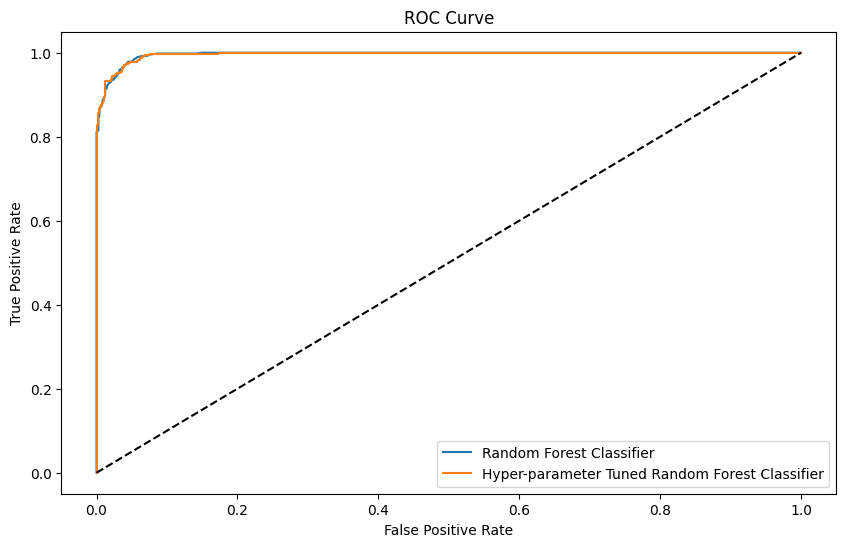

In [26]:
# plot ROC curve
plt.figure(figsize=(10, 6))
plt.plot(rf_fpr, rf_tpr, label='Random Forest Classifier')
plt.plot(best_rf_fpr, best_rf_tpr, label='Hyper-parameter Tuned Random Forest Classifier')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()

plt.plot([0, 1], [0, 1], linestyle='--', color='black')

plt.show()